# IMA204 Practical Session - Segmentation of medical images



## ADD your name(s) here: <br>

### Felipe SCHERER VICENTIN and Lorenza MARTINS GUIMARAES TARALLO 

# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK FIRST TO GET A FULL OVERVIEW OF USE-CASES AND THE NOTION OF HYPERPARAMETERS.**

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
import scipy
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


# PRINT VERSIONS
#print("os.__version__",os.__version__)
print("np.__version__",np.__version__)
print("matplotlib.__version__",matplotlib.__version__)
print("skimage.__version__",skimage.__version__)
print("scipy.__version__",scipy.__version__)
print("cv2.__version__",cv2.__version__)
#print("glob.__version__",glob.__version__)


np.__version__ 2.2.2
matplotlib.__version__ 3.10.0
skimage.__version__ 0.25.1
scipy.__version__ 1.15.1
cv2.__version__ 4.11.0


In [2]:
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors
    
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  ./data/abdominalCT_axial/CTs3.tiff
Label values in gt mask image [  0 127 255]


Text(0.5, 1.0, 'Image +contour tumor')

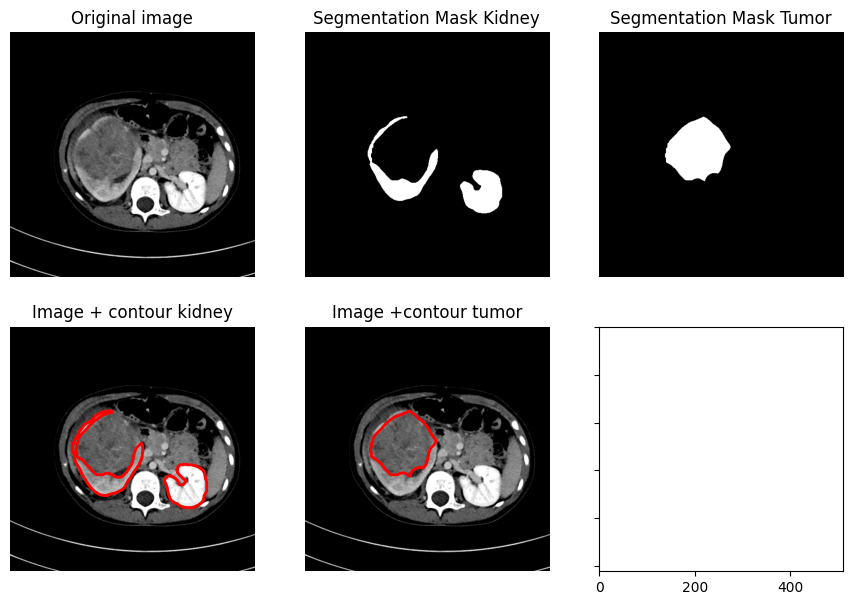

In [3]:
abdominalCT_path = './data/abdominalCT_axial'  
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=3 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print('Label values in gt mask image', np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['./data/brainMRI/MRIs1-seg.png', './data/brainMRI/MRIs2-seg.png', './data/brainMRI/MRIs3-seg.png', './data/brainMRI/MRIs4-seg.png']
Reading image  ./data/brainMRI/MRIs4.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

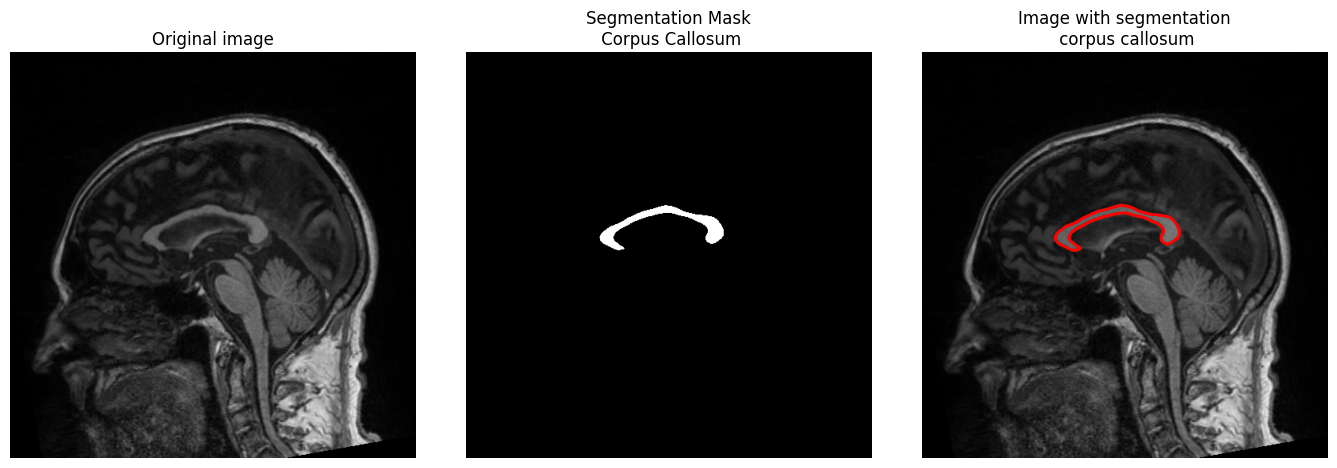

In [4]:
brainMRI_path = './data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value: [[-99999]]


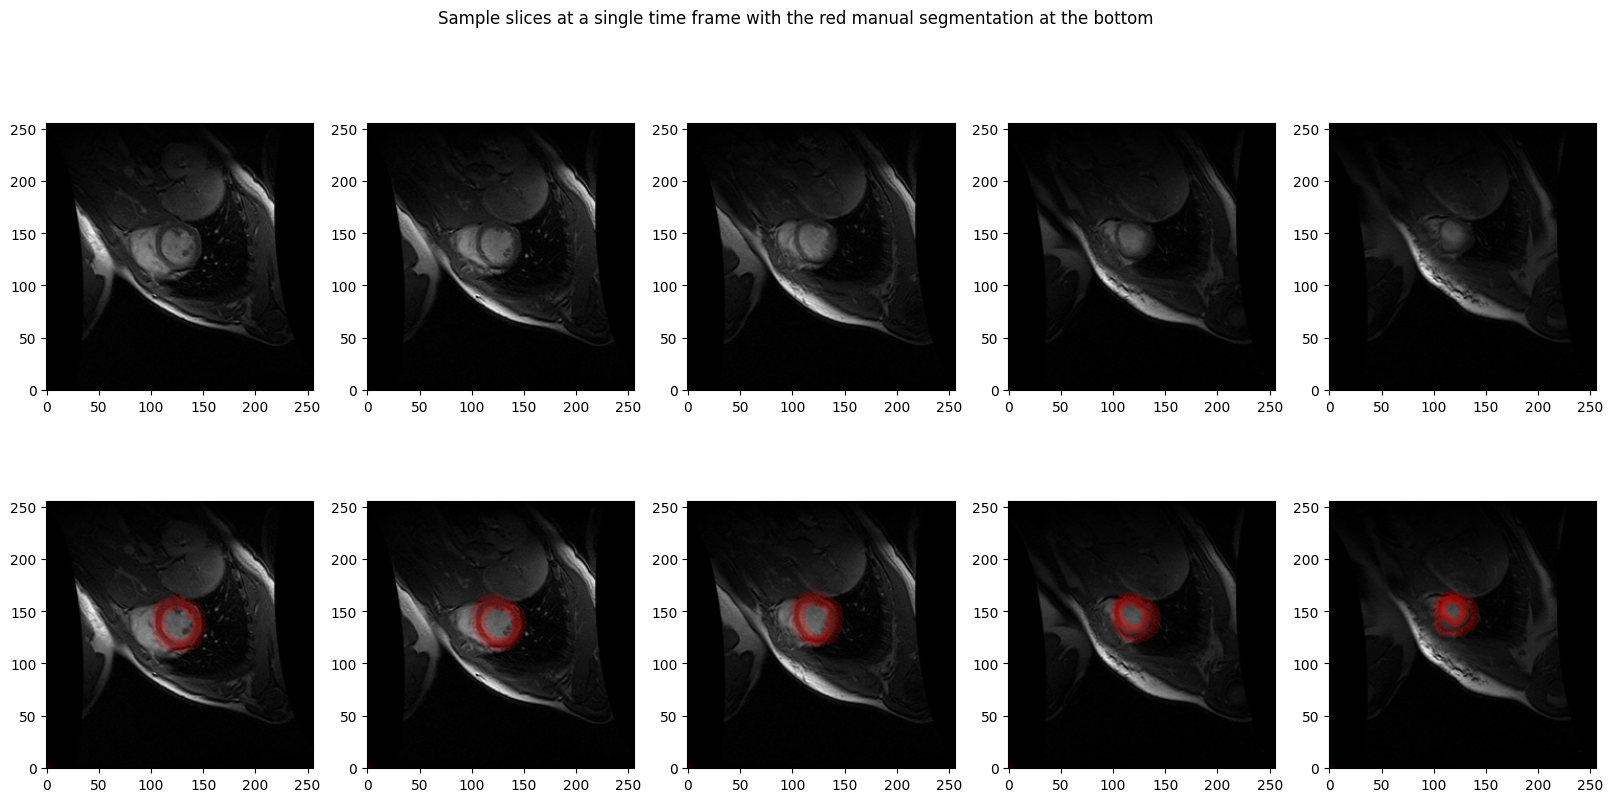

In [5]:

# Read one case
MRIheart_path = './data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 6
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Sample slices at a single time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1); 

## For cardiac MRI: how to create a binary mask from the provided contours

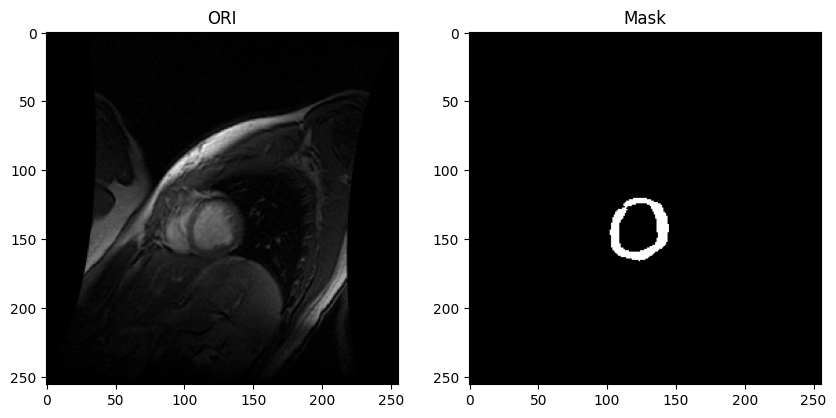

In [6]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incentives to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



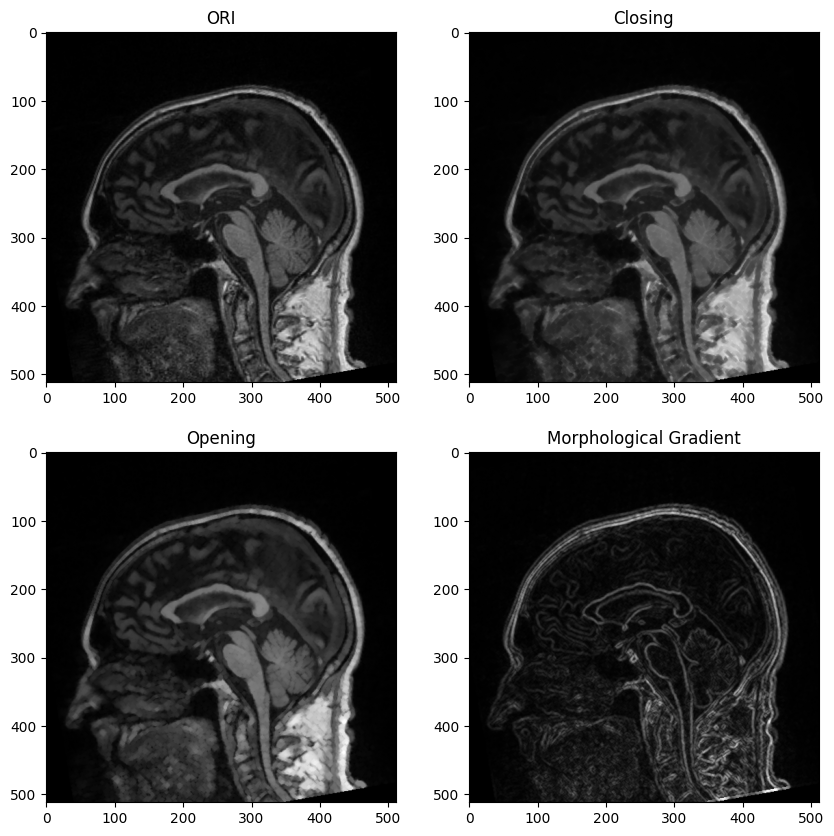

In [7]:
#Select input image
# Img_test         = Img_cardiac_ex
Img_test         = Img_brain_ex
# Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Morphological Gradient")

plt.show()

# Preliminaries
## Regular filtering

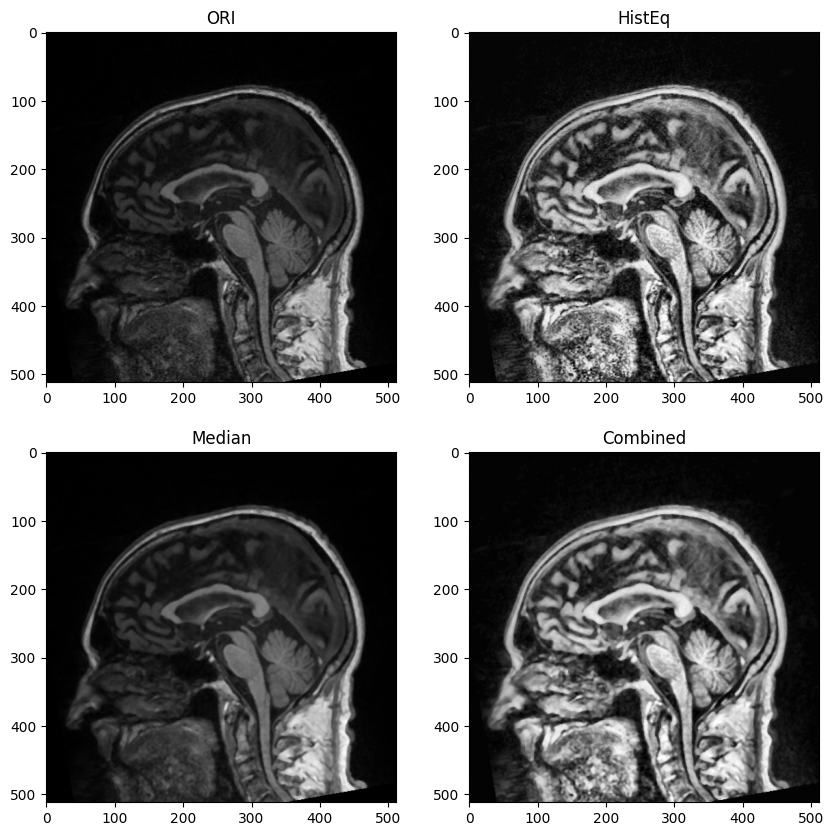

In [8]:

img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.02)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");




# ASSIGNMENT DETAILS:

__Overall task:__ <br> 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure(s) of interest**. For the postprocessing you can rely on extraction of connected components and apply some criteria (size, shape, position,..) to extract the component(s) that most likely correspond(s) to the structure(s) of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* __Cropping__ the field of view to remove the background (a common issue in medical images)
* Target a __range of intensity values__ based on learning from the gt masks and corresponding images you are given. 
* Learn __priors on shape/intensity statistics__ from the provided gt masks


## Kmeans routine to pre-segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

 



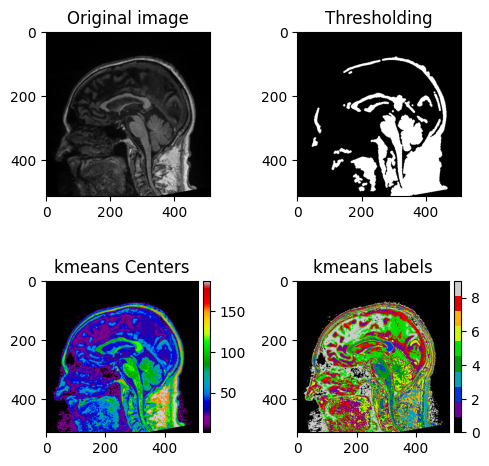

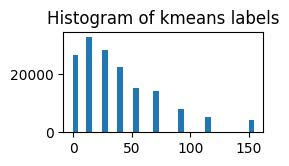

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Nber of classes in Kmeans (input)=  10
Your intensity Target_value =  97
Distance of your Target_value to Kmeans Centers =  [95 44 18 92  5 70 27 56 57 83]
Your selected label (starting with 0)=  4


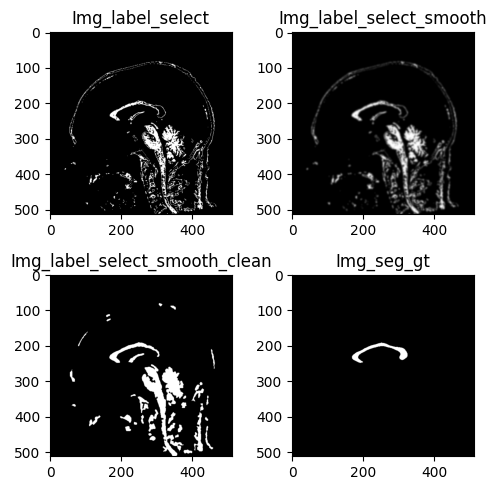

In [9]:
# Image use-case and HYPER-PARAMETER values provided as a good start

#Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
#nber_clusters    = 3; Target_value_thresh = 180 # For abdo image
#Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
#nber_clusters       = 10; Target_value_thresh = 150 # For cardiac  image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Figure: Display data
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')
tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')
tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')
fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
#Figure: plot histograms withins clusters from Kmeans
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
ax.set_title('Histogram of kmeans labels')
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
print(Seg_thresh)
Target_value = Target_value[0] 
Diff         = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)

# Prints: 
print('Nber of classes in Kmeans (input)= ', nber_clusters)
print('Your intensity Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Kmeans Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[0].set_title('Img_label_select')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[1].set_title('Img_label_select_smooth')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[2].set_title('Img_label_select_smooth_clean')
ax[3].imshow(Img_seg_gt, cmap='gray')
ax[3].set_title('Img_seg_gt')

fig.tight_layout()
plt.show()






## From Kmeans to Connected Components

This is an example on how to exploit the results from Kmeans.
Note that this example uses several hard-coded **hyperparameters** which is not appropriate to segment robustly several cases. 

If you reuse this piece of code for the question below, propose some approaches to set some of the hyperparameter values automatically (eg using the known average size of the structure of interest from the gt segmentation you have)
 



Max value in labels =  21
Number of connected components =  22


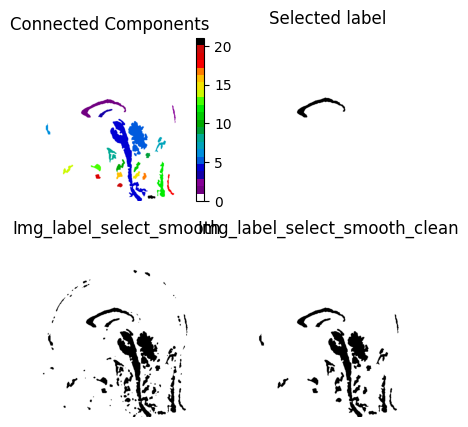

In [10]:
Img_label_select_filter = gaussian(Img_label_select, 2, 
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==1

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');




## Implement your full segmentation pipeline

### TO DO:
* Implement a full pipeline to segment __TWO EXAMPLES__ from a single use-case. You must print in the report that code which was  run over the two cases. We need to see in your code that your were able to run the same pipeline on two cases without changing any hyperparameter or changing them based on image-specific information. So comment the code and list all hyperparameter values clearly at the start of the cell. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>
<br>
* __Extra point(s) if__ :
    1. you provide results on more use-cases or more than 2 examples per use case. <br>
    2. you test your segmentation pipeline on images degraded by noise for example. <br>


### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

In [11]:
## Definition of hyperparameters

noise_factor = 8    # Factor of the intensity of the Gaussian noise added 
clip_limit = 0.02   # Clipping limit for adaptive histogram equalization

median_size = 5     # Size of the median filter used in preprocessing to reduce noise
closing_size = 1    # Size of the closing operation in morphological processing

k = 3               # Number of clusters for the K-means algorithm
cmap = my_colormap_white_bkg('nipy_spectral', k)  # Colormap for visualization of segmented images

morpho_disk_size = 1  # Disk size used in morphological operations
min_size = 50         # Minimum size threshold for removing small objects from the segmentation result
connectivity = 1      # Connectivity used in the removal of small objects

seed = 24             # numpy random seed

In [12]:
# Definition of quality metrics

from scipy.spatial.distance import directed_hausdorff

# Function that calculates the Dice coefficient
def dice(seg, gt):
    return 2.0 * np.sum(seg * gt) / (np.sum(seg) + np.sum(gt))

# Function that calculates the overlap ratio between seg and gt
def overlap(seg, gt):
    intersection = np.sum(seg * gt)
    union = np.sum((seg == 1) | (gt == 1))
    return intersection / union

# Function that calculates the relative difference in areas between seg and gt
def relative_area_differences(seg, gt):
    seg_area = np.sum(seg)
    gt_area = np.sum(gt)
    return abs(seg_area - gt_area) / gt_area

# Function to calculate contour-based metrics: mean surface distance and Hausdorff distance
def contour_distances(seg, gt):
    seg_contour = np.argwhere(seg == 1)  # Contour of segmentation
    gt_contour = np.argwhere(gt == 1)    # Contour of ground truth

    # Calculate mean surface distance
    mean_surface_distance = 0
    for point in seg_contour:
        mean_surface_distance += np.min(np.linalg.norm(gt_contour - point, axis=1))
    mean_surface_distance /= seg_contour.size
    
    return float(mean_surface_distance)

In [13]:
# Preprocessing the images

# Function to normalize a numpy array to the range [0, 1]
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Preprocessing function to apply median filter, equalization, and closing
def preprocess(img, median_size, equalize, closing_size):
    img = np.sqrt(img)        # Apply square root
    img = img / np.max(img)   # Normalize the image
    
    # Apply median filter
    if median_size > 0:
        img = ndimage.median_filter(img, size=median_size) 

    # Adaptive histogram equalization
    if equalize:
        img = skimage.exposure.equalize_adapthist(img, clip_limit=clip_limit)  

    # Morphological closing
    if closing_size > 0:
        img = morpho.closing(img, disk(closing_size))

    return cv2.resize(img, (256, 256))

# Calculate shape and intensity priors
def get_aspect_ratio(contour):
    bounding_box = cv2.boundingRect(contour)
    return bounding_box[2] / bounding_box[3]


def get_solidity(contour):
    area = cv2.contourArea(contour)
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    return area / hull_area

In [14]:
# Postprocessing the segmentation results

def postprocessing(img, labels, mean_gt, mean_solidity, mean_aspect_ratio):
    img_label_means = [cv2.mean(img, (labels == j).astype('uint8'))[0] for j in range(k)]
    label = np.argmin(np.absolute(img_label_means - mean_gt * np.ones(k)))
    
    binary_img = labels == label

    binary_img = morpho.opening(binary_img, disk(morpho_disk_size))                                         # Morphological opening
    binary_img = morphology.remove_small_objects(binary_img, min_size=min_size, connectivity=connectivity)  # Remove small objects
    binary_img = morpho.closing(binary_img, disk(morpho_disk_size))                                         # Morphological closing

    # Extract connected components and refine based on priors
    numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img.astype(np.uint8))
    aspect_ratios = []
    solidities = []
    
    for label in range(numLabels):
        contour = cv2.findContours((labels == label).astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]
        aspect_ratios.append(get_aspect_ratio(contour))
        solidities.append(get_solidity(contour))
    
    aspect_ratios = np.array(aspect_ratios)
    solidities = np.array(solidities)
    
    diffs_aspect_ratio = normalize(np.absolute(aspect_ratios - mean_aspect_ratio))
    diffs_solidity = normalize(np.absolute(solidities - mean_solidity))
    
    label = np.argmin(diffs_aspect_ratio + diffs_solidity)
    return labels == label

In [15]:
# Function to visualize results
def plot_result(original_img, img, gt, seg):
    plt.figure(figsize=(6, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(original_img, cmap="gray")
    plt.title("Original image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(img, cmap="gray")
    plt.title("Preprocessed image")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(gt, cmap=cmap)
    plt.title("Ground truth")
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    plt.imshow(seg, cmap=cmap)
    plt.title("Segmentation")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    print(f"Dice:                      {dice(seg, gt)}")
    print(f"Overlap:                   {overlap(seg, gt)}")
    print(f"Relative area differences: {relative_area_differences(seg, gt)}")
    print(f"Contour distance:          {contour_distances(seg, gt)}")

In [16]:
# Applying the pipeline and visualizing results

def segment(imgs_train, gts_train, imgs_test, gts_test):
    solidities = []
    aspect_ratios = []
    intensities = []
    
    for img, gt in zip(imgs_train, gts_train):
        img = preprocess(img, median_size, True, closing_size)
        gt = (preprocess(np.float32(gt), median_size, False, closing_size) > 0).astype(np.uint8)
        
        # Extract contour properties from ground truth
        contour = cv2.findContours(gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]
        
        # Calculate aspect ratio and solidity
        aspect_ratios.append(get_aspect_ratio(contour))
        
        solidities.append(get_solidity(contour))
        intensities.extend(img[gt == 1].flatten())

    mean_solidity = np.mean(solidities)
    mean_aspect_ratio = np.mean(aspect_ratios)

    # Calculate mean and standard deviation of pixel intensities within the segmented regions
    mean_gt = np.mean(intensities)
    
    # Process tests
    for original_img, gt in zip(imgs_test, gts_test):
        img = preprocess(original_img, median_size, True, closing_size)
        gt = (preprocess(np.float32(gt), median_size, False, closing_size) > 0).astype(np.uint8)
        
        colors, labels = my_kmeans(img, k)                                               # Apply K-means clustering
        corpus = postprocessing(img, labels, mean_gt, mean_solidity, mean_aspect_ratio)  # Apply post processing
        
        plot_result(original_img, img, gt, corpus)

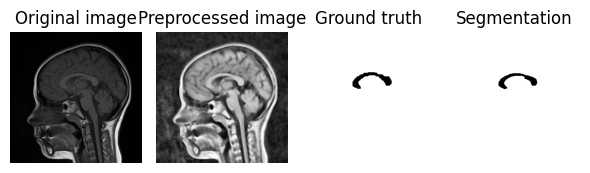

Dice:                      0.8891736066623959
Overlap:                   0.8004613610149942
Relative area differences: 0.12829736211031176
Contour distance:          0.025250878020714487


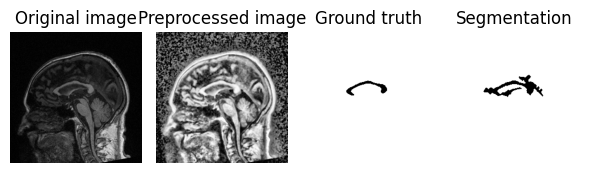

Dice:                      0.5487228003784295
Overlap:                   0.37809647979139505
Relative area differences: 1.6323024054982818
Contour distance:          2.5757967858533233


In [17]:
np.random.seed(seed) # Setting seed for random operations

# Adding Gaussian Noise 
def add_noise(img):
    return np.clip((img + noise_factor * np.random.randn(*img.shape)) / np.max(img), 0, 1)

imgs = [np.float32(imread(path.replace("-seg", ""))) for path in listImagesbrainMRI]  # Load images
gts = [imread(path) for path in listImagesbrainMRI]                                   # Load ground truths

imgs_noise = [add_noise(img) for img in imgs] # Apply noise to the images

imgs_train = imgs_noise[:2]
gts_train = gts[:2]

imgs_test = imgs_noise[2:]
gts_test = gts[2:]

segment(imgs_train, gts_train, imgs_test, gts_test)